In [49]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import numpy as np
import sklearn, sklearn.model_selection
import matplotlib
matplotlib.use('Agg');
import matplotlib.pyplot as plt
#plt.set_cmap('jet');
import random
import os, sys
import pickle
%matplotlib inline

a:13: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Tmp/lisa/os_v5/anaconda/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Tmp/lisa/os_v5/anaconda/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/part/01/Tmp/lisa/os_v5/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/u/cohenjos/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Tmp/lisa/os_v5/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File 

In [2]:
import sys
import argparse

if len(sys.argv) == 3 and sys.argv[1] == "-f": #on jupyter
    sys.argv = ['a','-thing']
    
parser = argparse.ArgumentParser()

parser.add_argument('-seed', type=int, nargs='?',default=0, help='random seed for split and init')
parser.add_argument('-nsamples', type=int, nargs='?',default=50, help='Number of samples for train')
parser.add_argument('-thing', default=False, action='store_true', help='Do the thing')


args = parser.parse_args()

In [3]:
print(args)

Namespace(nsamples=50, seed=0, thing=True)


In [4]:
exp_id = str(args).replace(" ","").replace("Namespace(","").replace(")","").replace(",","-").replace("=","")
print(exp_id)

nsamples50-seed0-thingTrue


In [5]:
torch.manual_seed(args.seed);
random.seed(args.seed)

In [6]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
cuda = torch.cuda.is_available()

In [8]:
BATCH_SIZE = 128

In [9]:
from torch.utils import data
import os
import skimage, skimage.transform
from skimage.io import imread, imsave

In [10]:
from PIL import Image
import skimage.filters

In [11]:
class TNTDataset(data.Dataset):
    'Tumor-NoTumor Dataset loader for PyTorch'
    def __init__(self, tntpath, subset="train", transform=None, blur=0):
        self.tntpath = tntpath
        self.subset = subset
        self.datapath = self.tntpath + "/" + self.subset + "/"
        self.imgs = sorted(os.listdir(self.datapath + "/flair"))
        self.transform = transform
        self.blur = blur

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        # Select sample
        filename = self.imgs[index]
        
        flair = imread(self.datapath + "/flair/" + filename)
        flair = Image.fromarray(flair)
        if self.transform != None:
            flair = self.transform(flair)
            
#         t1 = imread(self.datapath + "/t1/" + filename)
#         t1 = Image.fromarray(t1)
#         if self.transform != None:
#             t1 = self.transform(t1)
            
        seg = imread(self.datapath + "/segmentation/" + filename)
        seg = ((seg >= 30))*256.
        
        if self.blur > 0:
            seg = skimage.filters.gaussian(seg, self.blur)
            seg = seg/seg.max()
            
        seg = (seg > 0)*1.
        
        seg = Image.fromarray(seg)
        if self.transform != None:
            seg = self.transform(seg)
        
        
        has_tumor = ("True" in filename)

        return (flair, flair, seg), has_tumor 

In [12]:
mytransform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(100),
    torchvision.transforms.ToTensor()])

In [13]:
train = TNTDataset("/data/lisa/data/brats2013_tumor-notumor/", 
                   transform=mytransform,
                   blur=3)

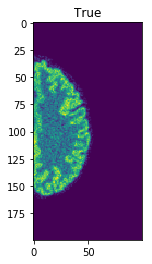

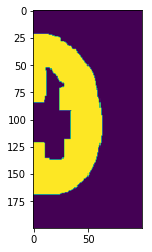

In [14]:
plt.imshow(train[5][0][0][0]);
plt.title(train[5][1]);
plt.show()
plt.imshow(train[5][0][2][0]);

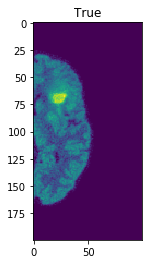

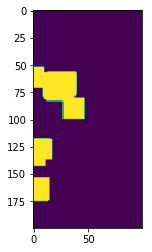

In [15]:
plt.imshow(train[250][0][0][0]);
plt.title(train[250][1]);
plt.show()
plt.imshow(train[250][0][2][0]);

In [16]:
# def f(x):
#     plt.imshow(train[x][0][1][0]);
#     plt.title(train[x][1]);
#     plt.show()
#     plt.imshow(train[x][0][2][0]);

# interact(f, x=(0,len(train),1));

In [17]:
tosplit = np.asarray([("True" in name) for name in train.imgs])
idx = range(tosplit.shape[0])
train_idx, valid_idx = sklearn.model_selection.train_test_split(idx, stratify=tosplit, train_size=0.75, random_state=args.seed)


/u/cohenjos/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [18]:
import collections
collections.Counter(tosplit)

Counter({False: 704, True: 1421})

In [19]:
print ("train_idx", len(train_idx))
print ("valid_idx", len(valid_idx))

train_idx 1593
valid_idx 532


In [20]:
#reduce samples
train_idx = train_idx[:args.nsamples]

In [21]:
print ("train_idx", len(train_idx))
print ("valid_idx", len(valid_idx))

train_idx 50
valid_idx 532


In [22]:
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=BATCH_SIZE, 
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(train_idx),
                                          num_workers=8)
valid_loader = torch.utils.data.DataLoader(dataset=train, batch_size=len(valid_idx), 
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(valid_idx),
                                          num_workers=8)

In [23]:
valid_data = list(valid_loader)
valid_x = Variable(valid_data[0][0][0]).cuda()
valid_y = valid_data[0][1].cuda()

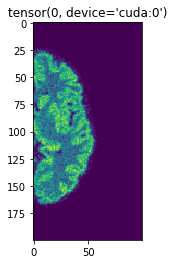

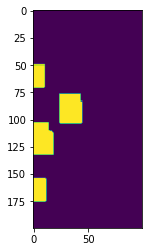

In [24]:
plt.imshow(valid_data[0][0][0][60][0]);
plt.title(valid_y[60]);
plt.show()
plt.imshow(valid_data[0][0][2][60][0]);


In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=64,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),     
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=32,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=16,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=8,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            nn.ReLU(),
        )
        self.out = nn.Linear(440, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

In [92]:
cnn = CNN()
if cuda:
    cnn = cnn.cuda()

print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU()
  )
  (out): Linear(in_features=440, out_features=2, bias=True)
)


In [93]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [94]:
use_gradmask = args.thing
stats = []

for epoch in range(300):
    batch_loss = []
    for step, (x, y) in enumerate(train_loader):
        
        b_x = Variable(x[0], requires_grad=True)
        b_y = Variable(y)
        seg_x = x[2]
        
        if cuda:
            b_x = b_x.cuda()
            b_y = b_y.cuda()
            seg_x = seg_x.cuda()

        cnn.train()
        output = cnn(b_x)[0]
        loss = loss_func(output, b_y)
        
        if use_gradmask:
            input_grads = torch.autograd.grad(outputs=torch.abs(output[:,1]).sum(), #loss,#torch.abs(output).sum(), 
                                       inputs=b_x, 
                                       #retain_graph=True, 
                                       create_graph=True)[0]
            
            #only apply to positive examples
            input_grads = b_y.float().reshape(-1,1,1,1)*input_grads
            
            res = input_grads * (1-seg_x.float())
            #res = torch.abs(res)
            gradmask_loss = epoch*(res**2).sum()
            loss = loss + gradmask_loss
            
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        batch_loss.append(loss.data[0])
        #print (loss)
    
    cnn.eval()
    test_output, last_layer = cnn(valid_x)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    #accuracy = float(sum(pred_y == valid_y.cuda())) / float(valid_y.size(0))
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_y.cpu())
    stat = {"epoch":epoch,
            "trainloss":np.asarray(batch_loss).mean(),
            "validauc": auc}
    stat.update(vars(args))
    stats.append(stat)
    print('Epoch: ', epoch, '| train loss: %.4f' % np.asarray(batch_loss).mean(), '| valid auc: %.2f' % auc)
    #os.mkdir("stats")
    pickle.dump(stats, open("stats/" + exp_id + ".pkl","wb"))     


Epoch:  0 | train loss: 0.7003 | valid auc: 0.50


a:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch:  1 | train loss: 0.7011 | valid auc: 0.50
Epoch:  2 | train loss: 0.6971 | valid auc: 0.50
Epoch:  3 | train loss: 0.6964 | valid auc: 0.50
Epoch:  4 | train loss: 0.6928 | valid auc: 0.50
Epoch:  5 | train loss: 0.6889 | valid auc: 0.50
Epoch:  6 | train loss: 0.6865 | valid auc: 0.50


KeyboardInterrupt: 

'nsamples50-seed0-thingTrue'

In [ ]:
#loss*10000*(res**2).sum()

In [1]:
import pickle
#os.mkdir("stats")
pickle.dump(stats, open("stats/" + exp_id + ".pkl","w"))   

NameError: name 'stats' is not defined

In [46]:
sys.exit()

SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


In [141]:
input_grads.shape

NameError: name 'input_grads' is not defined

In [31]:
b_y.float().unsqueeze(1).shape

torch.Size([50, 1])

In [33]:
filt = b_y.float().reshape(-1,1,1,1)*input_grads

In [142]:
plt.imshow(seg_x[0][0].cpu().detach().numpy());

NameError: name 'seg_x' is not defined

In [30]:
plt.imshow(filt[0][0].cpu().detach().numpy());

NameError: name 'filt' is not defined

In [33]:
input_grads = torch.autograd.grad(outputs=torch.abs(output[:,1]).sum(), 
                                       inputs=b_x, 
                                       #retain_graph=True, 
                                       create_graph=True)[0]

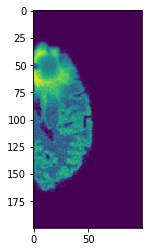

In [34]:
plt.imshow(b_x[10][0].cpu().detach().numpy())

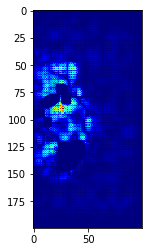

In [93]:
res = input_grads * (1-seg_x.float())
res = torch.abs(res)
plt.imshow(res[10][0].cpu().detach().numpy())

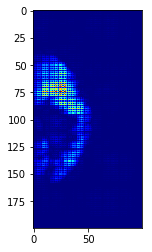

In [75]:
res = input_grads# * (1-seg_x.float())
res = torch.abs(res)
plt.imshow(res[5][0].cpu().detach().numpy())

In [35]:
x, y = train[250]

In [36]:
x[0].shape

torch.Size([1, 200, 100])

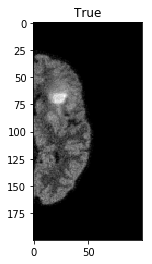

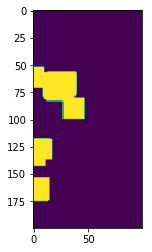

In [37]:
plt.imshow(x[0][0], cmap="gray");
plt.title(y);
plt.show()
plt.imshow(x[2][0]);

In [38]:
x_var = Variable(x[0].unsqueeze(0).cuda(), requires_grad=True)
pred = cnn(x_var)[0]

In [39]:
pred

tensor([[ 4.6118,  0.0441]], device='cuda:0')

In [40]:
input_grads = torch.autograd.grad(outputs=torch.abs(pred[:,1]).sum(), 
                                       inputs=x_var,
                                       create_graph=True)[0]

In [41]:
input_grads = input_grads[0][0].cpu().detach().numpy()

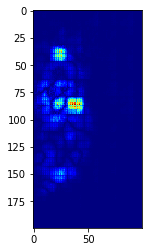

In [42]:
plt.imshow(np.abs(input_grads), cmap="jet");

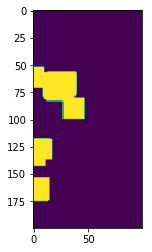

In [43]:
plt.imshow(x[2][0])

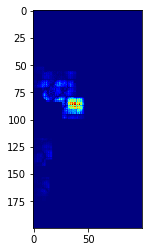

In [44]:
#these are the only allowed grads
masked_grads = np.abs(input_grads)*(x[2][0])
masked_grads[0][0] = torch.FloatTensor(np.abs(input_grads)).max()
plt.imshow(masked_grads, cmap="jet")

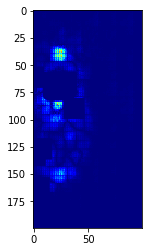

In [45]:
#We can regularize to reduce this
masked_grads = np.abs(input_grads)*(1-x[2][0])
masked_grads[0][0] = torch.FloatTensor(np.abs(input_grads)).max()
plt.imshow(masked_grads, cmap="jet")

In [ ]:
import skimage.filters
enlarged_mask = skimage.filters.gaussian(x[2][0].numpy(),15)
enlarged_mask = enlarged_mask/enlarged_mask.max()
enlarged_mask.max()

In [ ]:
plt.imshow(enlarged_mask)

In [59]:
#assuming the segmentations are sloppy we can enlarge the segmentations
masked_grads = input_grads*(1-enlarged_mask)
plt.imshow(masked_grads)

NameError: name 'enlarged_mask' is not defined

In [ ]:
#torch.save(cnn.state_dict(), "./classifier_model.pth")

In [ ]:
checkpoint = torch.load("./classifier_model.pth")
cnn.load_state_dict(checkpoint)

In [ ]:
# cnn.eval()
# test_output, last_layer = cnn(valid_x)
# pred_y = torch.max(test_output, 1)[1].data.squeeze()
# accuracy = float((pred_y == valid_y).sum()) / float(valid_y.size(0))
# print 'valid accuracy: %.2f' % accuracy

In [77]:
import pandas, os, pickle

In [162]:
df = pandas.DataFrame()
for f in os.listdir("stats"):
    d = (pickle.load(open("stats/" + f,"rb")))
    df = df.append(pandas.DataFrame(d))

In [163]:
df.nsamples.unique()

array([64, 20, 50])

In [169]:
df[(df.nsamples == 64)].groupby(["epoch","thing"]).count()

nsamples  seed  trainloss  validauc
epoch thing                                     
0     False        21    21         21        21
      True          8     8          8         8
1     False        21    21         21        21
      True          8     8          8         8
2     False        21    21         21        21
      True          8     8          8         8
3     False        21    21         21        21
      True          8     8          8         8
4     False        21    21         21        21
      True          8     8          8         8
5     False        21    21         21        21
      True          8     8          8         8
6     False        21    21         21        21
      True          8     8          8         8
7     False        21    21         21        21
      True          8     8          8         8
8     False        21    21         21        21
      True          8     8          8         8
9     False        21    21         21        21
      True          8     8          8         8
10    False        21    21         21        21
      True          8     8          8         8
11    False        21    21         21        21
      True          8     8          8         8
12    False        21    21         21        21
      True          8     8          8         8
13    False        21    21         21        21
      True          8     8          8         8
14    False        21    21         21        21
      True          8     8          8         8
...               ...   ...        ...       ...
285   False        21    21         21        21
      True          2     2          2         2
286   False        21    21         21        21
      True          2     2          2         2
287   False        21    21         21        21
      True          2     2          2         2
288   False        21    21         21        21
      True          2     2          2         2
289   False        21    21         21        21
      True          2     2          2         2
290   False        21    21         21        21
      True          2     2          2         2
291   False        21    21         21        21
      True          2     2          2         2
292   False        21    21         21        21
      True          2     2          2         2
293   False        21    21         21        21
      True          2     2          2         2
294   False        21    21         21        21
      True          2     2          2         2
295   False        21    21         21        21
      True          2     2          2         2
296   False        21    21         21        21
      True          2     2          2         2
297   False        21    21         21        21
      True          2     2          2         2
298   False        21    21         21        21
      True          2     2          2         2
299   False        21    21         21        21
      True          2     2          2         2

[600 rows x 4 columns]

In [165]:
df[(df.nsamples == 20)].groupby(["epoch","thing", "seed"]).mean()

nsamples     trainloss  validauc
epoch thing seed                                  
0     False 0           20  6.919444e-01  0.500000
            1           20  6.989049e-01  0.500000
            2           20  6.846856e-01  0.500000
            3           20  6.969714e-01  0.507182
            4           20  6.949903e-01  0.500000
            5           20  6.889799e-01  0.500000
            6           20  6.947677e-01  0.486402
            7           20  7.264372e-01  0.500000
            8           20  7.028760e-01  0.500000
            9           20  6.788788e-01  0.500000
            10          20  6.828734e-01  0.500000
            11          20  6.695714e-01  0.500000
            12          20  6.850557e-01  0.500000
            13          20  6.966583e-01  0.500000
            14          20  6.956902e-01  0.500000
            15          20  6.937159e-01  0.500000
            16          20  6.911975e-01  0.500000
            17          20  6.916073e-01  0.500000
            18          20  6.898153e-01  0.500000
            19          20  6.974484e-01  0.500000
            20          20  6.931289e-01  0.500000
      True  0           20  6.919444e-01  0.500000
            1           20  6.989049e-01  0.500000
            2           20  6.846856e-01  0.500000
            3           20  6.969714e-01  0.507182
            4           20  6.949903e-01  0.500000
            5           20  6.889799e-01  0.500000
            6           20  6.947677e-01  0.486402
            7           20  7.264372e-01  0.500000
            8           20  7.028760e-01  0.500000
...                    ...           ...       ...
299   False 12          20  1.922250e-05  0.625383
            13          20  4.918575e-05  0.679584
            14          20  2.861023e-07  0.710546
            15          20  5.478859e-05  0.704482
            16          20  6.791353e-05  0.733529
            17          20  1.519442e-04  0.727592
            18          20  1.603365e-05  0.768099
            19          20  2.303123e-05  0.595410
            20          20  4.742145e-05  0.722038
      True  0           20  4.942176e-02  0.685042
            1           20  8.637856e-02  0.670901
            2           20  1.641555e-01  0.604348
            3           20  1.826179e-02  0.701449
            4           20  5.696143e-03  0.797274
            5           20  3.694974e-02  0.714153
            6           20  1.293660e-01  0.699789
            7           20  1.625767e-01  0.525057
            8           20  2.066061e-02  0.814862
            9           20  2.243004e-02  0.778409
            10          20  3.976519e-02  0.735732
            11          20  6.105819e-02  0.716707
            12          20  6.094507e-02  0.690564
            13          20  1.657868e-02  0.688298
            14          20  4.236757e-01  0.755075
            15          20  2.220189e-02  0.703396
            16          20  6.838281e-02  0.770365
            17          20  6.382691e-03  0.751341
            18          20  1.088535e-02  0.809372
            19          20  6.276757e-03  0.608274
            20          20  1.175706e-02  0.745148

[12600 rows x 3 columns]

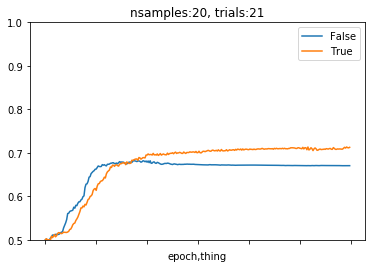

In [171]:
fig, ax = plt.subplots()
thisdata = df[(df.nsamples == 20)]
r = thisdata.groupby(["epoch","thing"]).mean().groupby("thing").plot(y="validauc", ax=ax)
plt.legend(df.thing.unique());
plt.title("nsamples:" + str(thisdata.nsamples.unique()[0]) + ", trials:" + str(thisdata.seed.unique().shape[0]));
plt.ylim(.5, 1.0);

In [189]:
r

thing
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

In [183]:
# fig, ax = plt.subplots()
# r = ss.mean().groupby("thing").plot(y="validauc", ax=ax, yerr=ss.std())
# #plt.legend(r)


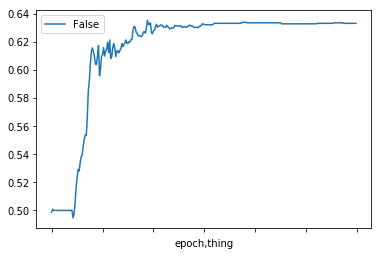

thing
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

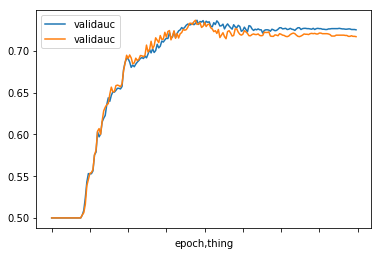

In [33]:
fig, ax = plt.subplots()
df[(df.nsamples == 50)].groupby(["epoch","thing"]).mean().groupby("thing").plot(y="validauc", ax=ax)

thing  nsamples
False  10          AxesSubplot(0.125,0.125;0.775x0.755)
       50          AxesSubplot(0.125,0.125;0.775x0.755)
       500         AxesSubplot(0.125,0.125;0.775x0.755)
True   10          AxesSubplot(0.125,0.125;0.775x0.755)
       50          AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

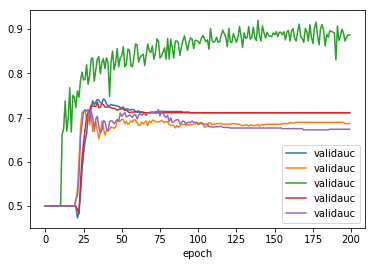

In [18]:
fig, ax = plt.subplots()
df.head(1000).groupby(["thing","nsamples"]).plot(x="epoch", y="validauc", ax=ax)

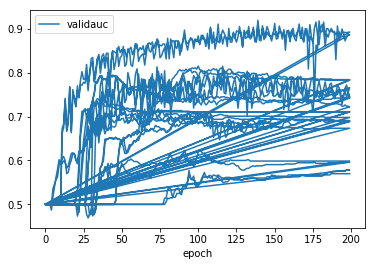

In [72]:
df.plot(x="epoch", y="validauc")